# Market Risk application

### Importing Libraries

In [6]:
#! pip install yfinance
#! pip install tabulate
#! pip install quandl
#! pip install pandas_datareader
#!pip install seaborn

In [7]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab

# Statistical calculation
from scipy.stats import norm

# Data fetching
import yfinance as yf

# DateTime
from datetime import date

# Tabular data output
from tabulate import tabulate

### Import data and calculating daily returns

In [8]:
# Import data for: , from: ,to:
data = yf.download('RELIANCE.NS', '2018-01-01',date.today())
df = pd.DataFrame(data['Close'])

[*********************100%***********************]  1 of 1 completed


In [9]:
#Calculate percent change
df['returns'] = df.Close.pct_change()

In [10]:
#Check top index
df.head()

,Close,returns
Date,,
2018-01-01,901.207458,NaN
2018-01-02,902.594299,0.001539
2018-01-03,906.210022,0.004006
2018-01-04,911.658386,0.006012
2018-01-05,914.580688,0.003205


In [11]:
#Check bottom index
df.tail()

,Close,returns
Date,,
2022-02-07,2317.100098,-0.006091
2022-02-08,2356.050049,0.016810
2022-02-09,2383.500000,0.011651
2022-02-10,2381.050049,-0.001028
2022-02-11,2376.399902,-0.001953


In [12]:
#Drop missings values
df = df.dropna()

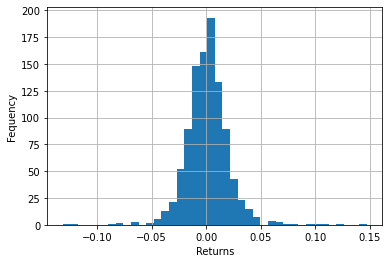

In [13]:
#Plot daily returns
plt.hist(df.returns, bins=40)
plt.xlabel('Returns')
df.sort_values('returns', inplace= True, ascending = True)
plt.ylabel('Fequency')
plt.grid(True)
plt.show()

In [14]:
#Sort the returns
df.sort_values('returns', inplace= True, ascending = True)

### Calculate Value-at-Risk - Historical Methods

In [15]:
VaR_90= df['returns'].quantile(0.1)
VaR_95= df['returns'].quantile(0.05)
VaR_99= df['returns'].quantile(0.01)

print(tabulate([['90%', round(VaR_90,4)*-1], ['95%', round(VaR_95,4)*-1], ["99%", round(VaR_99,4)*-1]],
               headers=['Confidence Level', 'Value at Risk']))

Confidence Level      Value at Risk
------------------  ---------------
90%                          0.0199
95%                          0.0265
99%                          0.0442


# Sample strategy

We decide to follow the below steps

Buy the stock on the fourth day open, if the stock closes up consecutively for three days.
Sell it on the fifth day open.

In [16]:
df_original = yf.download('RELIANCE.NS', '2018-01-01',date.today())

df = df_original.copy()

# Create open to open returns
df['oo_returns'] = np.log(df['Open'] / df['Open'].shift(1))

# Create close to close returns
df['cc_returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Generating trading signals
# Day 1 = Down day
# Day 2 = Down day
# Day 3 = Down day
# Day 4 = Buy at open

df['signals'] = np.where((df['cc_returns'].shift(1) < 0) &
                           (df['cc_returns'].shift(2) < 0) &
                           (df['cc_returns'].shift(3) < 0), 1, 0)

# To give the effect of buying on the next day open
df['signals'] = df['signals'].shift(1)

# Compute strategy returns

df['strategy_returns'] = df['signals'].shift(1) * df['oo_returns']

# Print returns

print('Buy and hold returns: ', np.round(df['cc_returns'].cumsum()[-1], 2))
print('Strategy returns: ', np.round(df['strategy_returns'].cumsum()[-1], 2))

[*********************100%***********************]  1 of 1 completed
Buy and hold returns:  0.97
Strategy returns:  -0.08


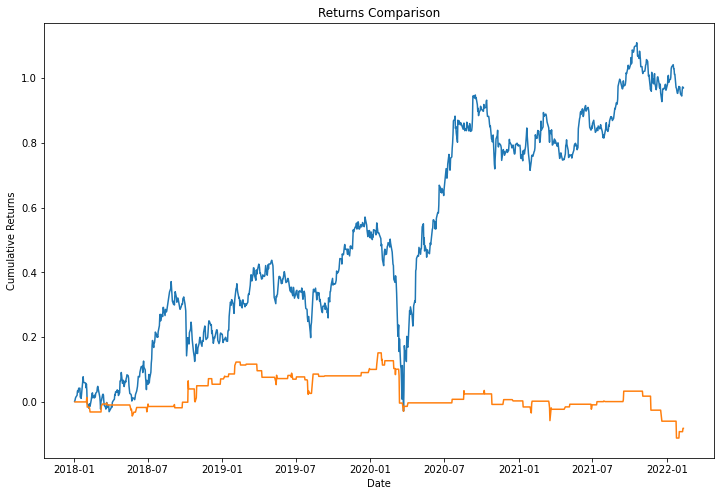

In [17]:
bnh = df['cc_returns'].cumsum()
s_returns = df['strategy_returns'].cumsum()

plt.figure(figsize = (12, 8))
plt.plot(bnh)
plt.plot(s_returns)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.title('Returns Comparison')
#plt.legend()
plt.show()

# Multi-Asset Portfolio

In [18]:
# Import Quandl - VaR and CVaR
import quandl
from pandas_datareader import data as pdr

In [19]:
# Create our portfolio of equities
tickers = ['BHARTIARTL.NS', 'INDIGO.NS','HDFCBANK.NS', 'RELIANCE.NS','TATAMOTORS.NS']

In [20]:
# Download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=date.today())['Close']

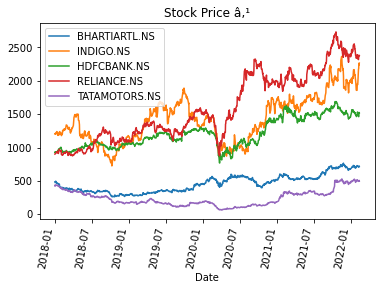

In [21]:
for i, col in enumerate(data.columns):
   
  data[col].plot()
plt.title('Stock Price â‚¹')
plt.xticks(rotation=80)
plt.legend(data.columns)

1017

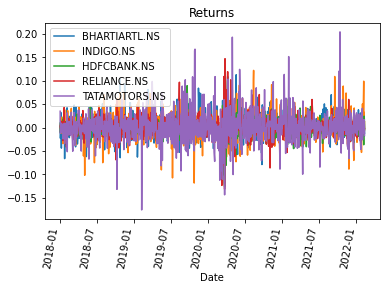

In [22]:
#From the closing prices, calculate periodic returns
returns = data.pct_change()

returns.tail()

for i, col in enumerate(returns.columns):
   
  returns[col].plot()
plt.title('Returns')
plt.xticks(rotation=80)
plt.legend(returns.columns)

length = len(returns)
length

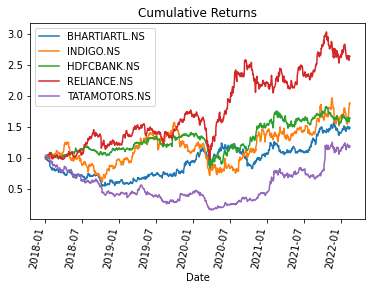

In [23]:
# Cumulative plot
returns_cumulative = (returns+1).cumprod()

for i, col in enumerate(returns.columns):
   
  returns_cumulative[col].plot()
plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(returns_cumulative.columns)

In [24]:
VaR_95_AIRTEL = norm.ppf(1-0.95, returns['BHARTIARTL.NS'].mean(), returns['BHARTIARTL.NS'].std())
VaR_95_HDFC = norm.ppf(1-0.95, returns['HDFCBANK.NS'].mean(), returns['HDFCBANK.NS'].std())
VaR_95_INDIGO = norm.ppf(1-0.95, returns['INDIGO.NS'].mean(), returns['INDIGO.NS'].std())
VaR_95_RIL = norm.ppf(1-0.95, returns['RELIANCE.NS'].mean(), returns['RELIANCE.NS'].std())
VaR_95_TATA = norm.ppf(1-0.95, returns['TATAMOTORS.NS'].mean(), returns['TATAMOTORS.NS'].std())

print(tabulate([['AIRTEL', round(VaR_95_AIRTEL,4)*-1], ['HDFC', round(VaR_95_HDFC,4)*-1],
                ['INDIGO', round(VaR_95_INDIGO,4)*-1], ['RELIANCE', round(VaR_95_RIL,4)*-1],
                ['TATA MOTORS', round(VaR_95_TATA,4)*-1]],
               headers=['Asset', 'Value at Risk @ 95%']))

Asset          Value at Risk @ 95%
-----------  ---------------------
AIRTEL                      0.0362
HDFC                        0.0274
INDIGO                      0.0424
RELIANCE                    0.0326
TATA MOTORS                 0.053


In [25]:
# Generate Correlation matrix
corr_matrix = returns.corr().round(2)
corr_matrix

Symbols,BHARTIARTL.NS,INDIGO.NS,HDFCBANK.NS,RELIANCE.NS,TATAMOTORS.NS
Symbols,,,,,
BHARTIARTL.NS,1.00,0.18,0.31,0.28,0.28
INDIGO.NS,0.18,1.00,0.26,0.22,0.26
HDFCBANK.NS,0.31,0.26,1.00,0.42,0.34
RELIANCE.NS,0.28,0.22,0.42,1.00,0.35
TATAMOTORS.NS,0.28,0.26,0.34,0.35,1.00


In [26]:
# Set the investment weights (I arbitrarily picked for example)
weights = np.array([0.20, 0.20, 0.20, 0.20, 0.20])

In [27]:
# Calculate mean returns for each stock
avg_rets = returns.mean()

In [29]:
# Calculate mean returns for portfolio overall,
# using dot product to
# normalize individual means against investment weights

port_mean = avg_rets.dot(weights)
 
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(corr_matrix).dot(weights))

In [30]:
# Select our confidence interval (I'll choose 95% here)
VaR_Level = 0.95

In [31]:
# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above

VaR_Portfolio = norm.ppf(1-VaR_Level, port_mean, port_stdev)
print(['Parametric Portfolio VaR 95% Confidence Level:', round(VaR_Portfolio,4)*-1])

['Parametric Portfolio VaR 95% Confidence Level:', 1.0803]


In [32]:
print(['Parametric Portfolio VaR 95% Confidence Level:', round(VaR_Portfolio,4)*-1])

['Parametric Portfolio VaR 95% Confidence Level:', 1.0803]


In [33]:
# Summarize Value at Risk
print(tabulate([['AIRTEL', round(VaR_95_AIRTEL,4)*-1], ['HDFC', round(VaR_95_HDFC,4)*-1],
                ['INDIGO', round(VaR_95_INDIGO,4)*-1], ['RELIANCE', round(VaR_95_RIL,4)*-1],
                ['TATA MOTORS', round(VaR_95_TATA,4)*-1],['Portfolio', round(VaR_Portfolio,4)*-1]],
               headers=['Asset', 'Value at Risk @ 95%']))

Asset          Value at Risk @ 95%
-----------  ---------------------
AIRTEL                      0.0362
HDFC                        0.0274
INDIGO                      0.0424
RELIANCE                    0.0326
TATA MOTORS                 0.053
Portfolio                   1.0803


In [34]:
# Summarize Asset Return
print(tabulate([['AIRTEL', round(returns['BHARTIARTL.NS'].mean(),4)], ['HDFC', round(returns['HDFCBANK.NS'].mean(),4)],
                ['INDIGO', round(returns['INDIGO.NS'].mean(),4)], ['RELIANCE', round(returns['RELIANCE.NS'].mean(),4)],
                ['TATA MOTORS', round(returns['TATAMOTORS.NS'].mean(),4)],['Portfolio', round(port_mean,4)]],
               headers=['Asset', 'Average Daily Return']))

Asset          Average Daily Return
-----------  ----------------------
AIRTEL                       0.0006
HDFC                         0.0006
INDIGO                       0.001
RELIANCE                     0.0012
TATA MOTORS                  0.0007
Portfolio                    0.0008


In [35]:
asset_mean = returns.mean()
asset_mean

Symbols
BHARTIARTL.NS    0.000632
INDIGO.NS        0.000971
HDFCBANK.NS      0.000631
RELIANCE.NS      0.001165
TATAMOTORS.NS    0.000685
dtype: float64

In [36]:
# Compare Risk vs. Return
print(tabulate([['AIRTEL', round(returns['BHARTIARTL.NS'].mean(),4), round(VaR_95_AIRTEL,4)*-1],
                ['HDFC', round(returns['HDFCBANK.NS'].mean(),4), round(VaR_95_HDFC,4)*-1],
                ['INDIGO', round(returns['INDIGO.NS'].mean(),4), round(VaR_95_INDIGO,4)*-1],
                ['RELIANCE', round(returns['RELIANCE.NS'].mean(),4), round(VaR_95_RIL,4)*-1],
                ['TATA MOTORS', round(returns['TATAMOTORS.NS'].mean(),4),round(VaR_95_TATA,4)*-1],
                ['Portfolio', round(port_mean,4), round(VaR_Portfolio,4)*-1]],
               headers=['Confidence Level', 'Average Daily Return','Value at Risk @ 95%']))

Confidence Level      Average Daily Return    Value at Risk @ 95%
------------------  ----------------------  ---------------------
AIRTEL                              0.0006                 0.0362
HDFC                                0.0006                 0.0274
INDIGO                              0.001                  0.0424
RELIANCE                            0.0012                 0.0326
TATA MOTORS                         0.0007                 0.053
Portfolio                           0.0008                 1.0803


# Capital Asset Pricing Model

In [37]:
# Import data for Market Index - NASDAQ ticket GSPC
market_data = pdr.get_data_yahoo('^BSESN', start="2018-01-01", end=date.today())['Close']

In [38]:
#From the closing prices, calculate periodic returns
market_returns = market_data.pct_change()

In [39]:
market_returns.tail()

Date
2022-02-07   -0.017455
2022-02-08    0.003252
2022-02-09    0.011372
2022-02-10    0.007869
2022-02-11   -0.013120
Name: Close, dtype: float64

In [40]:
# Avearge market retun
market_mean = market_returns.mean()
market_VaR = norm.ppf(1-0.95, market_returns.mean(), market_returns.std())
market_mean

0.0006180112546178899

In [41]:
# Risk Free Rate
risk_free_rate = 0.04/252

In [42]:
# Portfolio Beta
port_beta = (port_mean - risk_free_rate)/market_mean
port_beta

1.064317091865635

In [43]:
# Select Asset to calculate Beta
Asset = returns['RELIANCE.NS']
asset_mean = Asset.mean()
asset_VaR = norm.ppf(1-0.95, Asset.mean(), Asset.std())

In [44]:
# Beta of an Asset
asset_beta = (asset_mean - risk_free_rate)/market_mean
asset_beta

1.627844299846949

In [45]:
# Beta in down market
asset_beta_down = (Asset[Asset<0].mean() - risk_free_rate)/market_returns[market_returns<0].mean()
asset_beta_down

1.666381363760049

In [46]:
# Beta in up market
asset_beta_up = (Asset[Asset>=0].mean() - risk_free_rate)/market_returns[market_returns>=0].mean()
asset_beta_up

1.7661820170351827

In [47]:
# Time Ratio
asset_time_ratio = asset_beta_up/asset_beta_down
asset_time_ratio

1.0598906441499933

# Sharpe ratio

In [48]:
# sharpe ratio
sharpe_ratio_portfolio = (port_mean - risk_free_rate) / VaR_Portfolio*-1

In [49]:
sharpe_ratio_asset = (asset_mean - risk_free_rate) / asset_VaR*-1

In [50]:
sharpe_ratio_market = (market_mean - risk_free_rate) / market_VaR*-1

In [51]:
print(tabulate([['Asset', sharpe_ratio_asset],
                ['Market', sharpe_ratio_market],
                ['Portfolio', sharpe_ratio_portfolio]],
               headers=['Asset', 'Sharpe Ratio']))

Asset        Sharpe Ratio
---------  --------------
Asset         0.0308377
Market        0.0226533
Portfolio     0.000608873


# Max Sharpe Ratio - Portfolio

In [54]:
# Download closing prices
import pandas_datareader as web

tickers = ['BHARTIARTL.NS', 'INDIGO.NS','HDFCBANK.NS', 'RELIANCE.NS','TATAMOTORS.NS']
closes = web.get_data_yahoo(tickers, start="2015-01-01", end=date.today())['Close']
closes.tail()

Symbols,BHARTIARTL.NS,INDIGO.NS,HDFCBANK.NS,RELIANCE.NS,TATAMOTORS.NS
Date,,,,,
2022-02-07,706.500000,2170.100098,1468.150024,2317.100098,494.600006
2022-02-08,708.900024,2182.600098,1461.849976,2356.050049,492.750000
2022-02-09,719.349976,2253.800049,1497.599976,2383.500000,501.250000
2022-02-10,724.049988,2236.750000,1525.099976,2381.050049,507.450012
2022-02-11,715.150024,2264.949951,1518.849976,2376.399902,498.850006


In [55]:
!pip install web

ERROR: Could not find a version that satisfies the requirement web (from versions: none)
ERROR: No matching distribution found for web


In [56]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))

In [57]:
daily_returns = calc_daily_returns(closes)
daily_returns.tail()

Symbols,BHARTIARTL.NS,INDIGO.NS,HDFCBANK.NS,RELIANCE.NS,TATAMOTORS.NS
Date,,,,,
2022-02-07,-0.019206,0.094534,-0.037335,-0.006110,-0.012058
2022-02-08,0.003391,0.005744,-0.004300,0.016670,-0.003747
2022-02-09,0.014633,0.032101,0.024161,0.011583,0.017103
2022-02-10,0.006512,-0.007594,0.018196,-0.001028,0.012293
2022-02-11,-0.012368,0.012529,-0.004107,-0.001955,-0.017093


In [58]:
mean_daily_returns = np.array(daily_returns.mean()).reshape(-1, 1)
mean_daily_returns

array([[4.34925175e-04],
       [6.14323787e-04],
       [6.60728002e-04],
       [9.60742820e-04],
       [6.53248667e-06]])

In [60]:
# Create NULL Objects and define Risk free rate
srs = []
portfolio_stds = []
rand_wts = []
portfolio_returns = []
risk_free_rate = 0

# Define number of iterations
for i in range(0, 20000):
    random_weights = np.random.dirichlet(np.ones(5), size = 1).T
    rand_wts.append(random_weights)
    # portolfio return
    portfolio_return = np.sum(mean_daily_returns * random_weights)*252 #Annulaized
    portfolio_returns.append(portfolio_return)
    # portfolio volatility
    portfolio_std = np.sqrt(np.dot(random_weights.T, np.dot(corr_matrix, random_weights))) * np.sqrt(252) #Annulaized
    portfolio_stds.append(portfolio_std)
    # sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    srs.append(sharpe_ratio)

In [61]:
# Calculate portfolio values
max_index = srs.index(max(srs))
best_wts = rand_wts[max_index]
max_sr = srs[max_index]
portfolio_sd = portfolio_stds[max_index]
max_return = portfolio_returns[max_index]

In [62]:
# Print output
print(f"Max Sharpe Ratio: {max_sr}")
print(f"Best Weights: {best_wts.T}")
print(f"Portfolio Volatility: {portfolio_sd*100}%, Sum of weights: {np.sum(best_wts)}")
print(f"Max Expected Annual Return: {round(max_return*100,1)}%")

Max Sharpe Ratio: [[0.01691869]]
Best Weights: [[7.84083573e-02 2.36917958e-01 9.79070746e-02 5.86757516e-01
  9.09487631e-06]]
Portfolio Volatility: [[1203.58577404]]%, Sum of weights: 1.0
Max Expected Annual Return: 20.4%


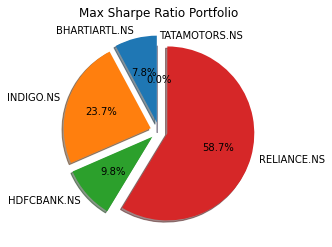

In [63]:
pie_labels = list(daily_returns.columns)
pie_data = best_wts.T.flatten()
pie_explode = [0.1, 0.1, 0.1, 0.1, 0]

# Pie set up
plt.pie(pie_data, explode = pie_explode, labels = pie_labels, startangle = 90, shadow = True, autopct='%1.1f%%')

# displaying the title
plt.title("Max Sharpe Ratio Portfolio")

plt.show()